# Product demand forecasting

## Research topic
The aim of this project is to forecast product demand.  It will be implemented using X as a baseline and using Y.

## Dataset
The data was uploaded to Kaggle; [Demand forecasting](https://www.kaggle.com/datasets/aswathrao/demand-forecasting?select=train_0irEZ2H.csv). A training and testing split is already provided within the dataset, but the test data provided doesn't have the actual values. As such, a separate split is made between training and testing to be able to evaluate the results.

<a id='contents'></a>
## Contents
1. [Data preparation](#data_exam)
2. [Baselines](#baselines)
3. [Models](#models)
4. [Review](#review)

## Packages and set up

In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.axes as axes
import seaborn as sns
import datetime as dt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import keras_tuner

seed = 15

2023-05-26 14:25:18.137325: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<a id='data_exam'></a>
## Data preparation
[Back to contents](#contents)

1. [Data exploration](#expl)
2. [Data formatting](#form)

The data set has a number of different columns:
- record_ID gives each entry a unique index
- week indicates the week the entry is from
- store_id references which of the 76 stores the entry refers to
- sku_id is the stock keeping unit, or product id
- total_price and base price are the actual sale price and usual sale price respectively
- is_featured_sku and is_display_sku indicate when the product has been specifically featured or displayed
- unites_sold is the number of items sold for that store and product in the specific week. This is the target value for prediction.

The data now needs to be split into training and test. The test data will take the last 12 weeks as used for the original split.

In [2]:
raw_data = pd.read_csv('all_data.csv', index_col='record_ID', parse_dates=True)
raw_data.columns = raw_data.columns.str.lower()
raw_data['week'] = pd.to_datetime(raw_data['week'], format='%d/%m/%y')

display(raw_data.head())
display(raw_data.nunique())

print("Min total price:", min(raw_data['total_price']))
print("Max total price:", max(raw_data['total_price']))
print("Min base price:", min(raw_data['base_price']))
print("Max base price:", max(raw_data['base_price']))

,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
record_ID,,,,,,,,
1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20
2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28
3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19
4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44
5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52


week               130
store_id            76
sku_id              28
total_price        646
base_price         572
is_featured_sku      2
is_display_sku       2
units_sold         708
dtype: int64

Min total price: 41.325
Max total price: 562.1625
Min base price: 61.275
Max base price: 562.1625


In [3]:
raw_data[raw_data.isna().any(axis=1)]

,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
record_ID,,,,,,,,
193915,2013-04-23,9436,245338,NaN,469.5375,0,0,1


There is one NaN in the whole dataframe, in total_price. This can be set to the base_price as an estimate. Given it is only one data point, would seem excessive to extrapolate from other data.

In [4]:
raw_data['total_price'][193915] = raw_data['base_price'][193915]
raw_data['week_no'] = round((raw_data['week']-dt.datetime(year=2011,month=1,day=17)).dt.days/7)

train_data = raw_data[raw_data['week_no']<max(raw_data['week_no']-11)].copy()
test_data = raw_data[raw_data['week_no']>=max(raw_data['week_no']-11)].copy()

/var/folders/kf/60czhf056b36zn8cn741kcn80000gn/T/ipykernel_92478/2087273164.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['total_price'][193915] = raw_data['base_price'][193915]


<a id='expl'></a>
### Data exploration
[Back to data preparation](#data_exam)

A few basic plots will help with examining the distribution of the data points by the different variables. The models will be built on the time series as a whole, ignoring the split between stores and products due to the high numbers of each. This would be an interesting way to expand the models further.

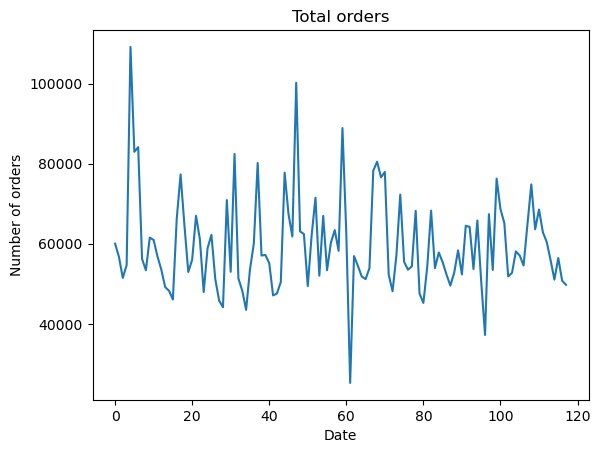

In [5]:
plt_data = train_data.groupby(["week"], as_index=False)["units_sold"].sum()

plt.plot(plt_data['units_sold'])

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.title('Total orders')

plt.show()

In [6]:
print("Min order:", min(train_data['units_sold']))
print("Max order:", max(train_data['units_sold']))
print("Min no. entries for each week:" ,min(train_data.groupby(["week"], as_index=False)["units_sold"].count()['units_sold']))
print("Max no. entries for each week:" ,max(train_data.groupby(["week"], as_index=False)["units_sold"].count()['units_sold']))
print("Store x item combos:", 76*28)
print("Big dip:", plt_data[min(plt_data['units_sold'])==plt_data['units_sold']])


Min order: 1
Max order: 2876
Min no. entries for each week: 1155
Max no. entries for each week: 1155
Store x item combos: 2128
Big dip:          week  units_sold
61 2012-03-20       25220


The total number of orders stays between 20,000 and 12,000 for every week. The same number of data points are provided for every week. However, not every product is ordered for every store in every week. 

There is a large dip in the data in March 2012. Yet in that week there are still the same number of data entries and none of them are zero. 

In [7]:
print("Store ids:")
plt_data = train_data.drop_duplicates(subset=['week', 'store_id'], keep='first').groupby(["store_id"], as_index=False)["week"].count()
print(plt_data.groupby(['week'], as_index=False)['store_id'].count().rename(columns={'week':'Appearances', 'store_id': 'Count'}))

print()
print("SKU ids:")
plt_data = train_data.drop_duplicates(subset=['week', 'sku_id'], keep='first').groupby(["sku_id"], as_index=False)["week"].count()
print(plt_data.groupby(['week'], as_index=False)['sku_id'].count().rename(columns={'week':'Appearances', 'sku_id': 'Count'}))

print()
print("Store and SKU ids together:")
plt_data = train_data.copy()
plt_data['store_sku'] = plt_data['store_id']+plt_data['sku_id']
plt_data = plt_data.drop_duplicates(subset=['week', 'store_sku'], keep='first').groupby(["store_sku"], as_index=False)["week"].count()
print(plt_data.groupby(['week'], as_index=False)['store_sku'].count().rename(columns={'week':'Appearances', 'store_sku': 'Count'}))



Store ids:
   Appearances  Count
0          118     76

SKU ids:
   Appearances  Count
0          118     28

Store and SKU ids together:
   Appearances  Count
0          118   1113


So all stores and all SKUs appear every week. In addition, it is the same combinations of stores and SKUs appearing each week.

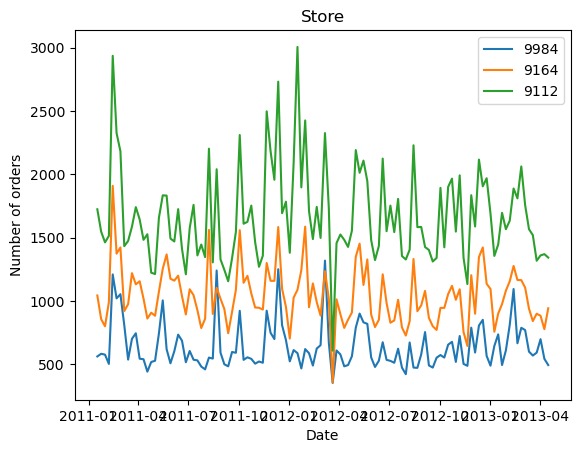

In [8]:
plt_data = train_data.groupby(['week', 'store_id', 'sku_id'], as_index=False)["units_sold"].sum().sort_values('week', ascending=False)
plt_data_ids = list(plt_data['store_id'])[:3]
plt_data = pd.pivot(train_data.groupby(["week", "store_id"], as_index=False)["units_sold"].sum(), index='week', columns='store_id', values='units_sold')

for store in plt_data_ids:
    plt.plot(plt_data[store], label=store)

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.title('Store')
plt.legend()

plt.show()

Three stores are chosen for this plot to get an impression of how the individual store data may differ from the overall pattern. The three stores all follow vaguely similar shapes. All three have a drop off at the major dip, and also a similar early peak. Although modelling the store separately might improve results, from this very small snapshot it appears that it may not make too much difference.

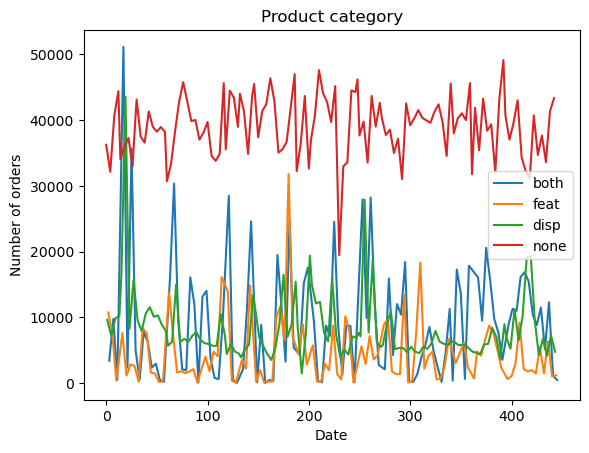

In [9]:
train_fd = train_data.groupby(['week', 'is_featured_sku', 'is_display_sku'], axis=0, as_index=False)['units_sold'].sum()

conditions = [
    (train_fd['is_featured_sku'] == 1) & (train_fd['is_display_sku'] == 1),
    (train_fd['is_featured_sku'] == 1) & (train_fd['is_display_sku'] == 0),
    (train_fd['is_featured_sku'] == 0) & (train_fd['is_display_sku'] == 1),
    (train_fd['is_featured_sku'] == 0) & (train_fd['is_display_sku'] == 0)]

values = ['both', 'feat', 'disp', 'none']

train_fd['cat'] = np.select(conditions, values)

for cat in values:
    plt.plot(train_fd[train_fd['cat']==cat]['units_sold'], label=cat)

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.title('Product category')
plt.legend()

plt.show()

The columns in the data for 'is_featured_sku' and 'is_display_sku' appear to indicate when a product has either been specially displayed or featured. All 4 combinations appear in the data; both featured and displayed, one or the other and neither. As might be expected, the products sold that are not specially featured are generally much higher. It is these products where the large drop in numbers is seen. There is however a big spike in the other categories towards the start of the time period.

<a id='form'></a>
### Data formatting
[Back to data preparation](#data_exam)

The data needs to be prepared for use. The date is split into year, month and day although the weekday is not considered as it is really weekly data rather than being connected only to the day shown.

In [10]:
# Split up year, month and day
train_data['year'], train_data['month'], train_data['day'] = train_data['week'].dt.year, train_data['week'].dt.month, train_data['week'].dt.day
test_data['year'], test_data['month'], test_data['day'] = test_data['week'].dt.year, test_data['week'].dt.month, test_data['week'].dt.day

display(train_data.head())

,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,week_no,year,month,day
record_ID,,,,,,,,,,,,
1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20,0.0,2011,1,17
2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28,0.0,2011,1,17
3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19,0.0,2011,1,17
4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44,0.0,2011,1,17
5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52,0.0,2011,1,17


#### Seasonality

There may be seasonality in supply data. This can be examined with a Fourier transform.

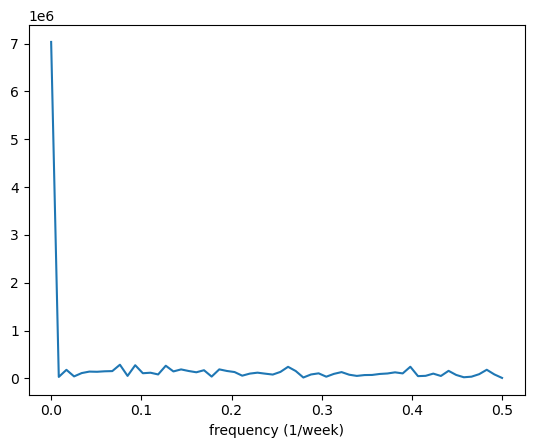

In [11]:
plt_data = train_data.groupby(["week"], as_index=False)["units_sold"].sum()

x = list(range(len(plt_data.index))) 
y = plt_data['units_sold']

# Absolute value of the Fourier transform
f=abs(np.fft.rfft(y))

# List of frequencies
freq = np.fft.rfftfreq(len(x))

plt.plot(freq, f)
    
plt.xlabel('frequency (1/week)')
plt.show()

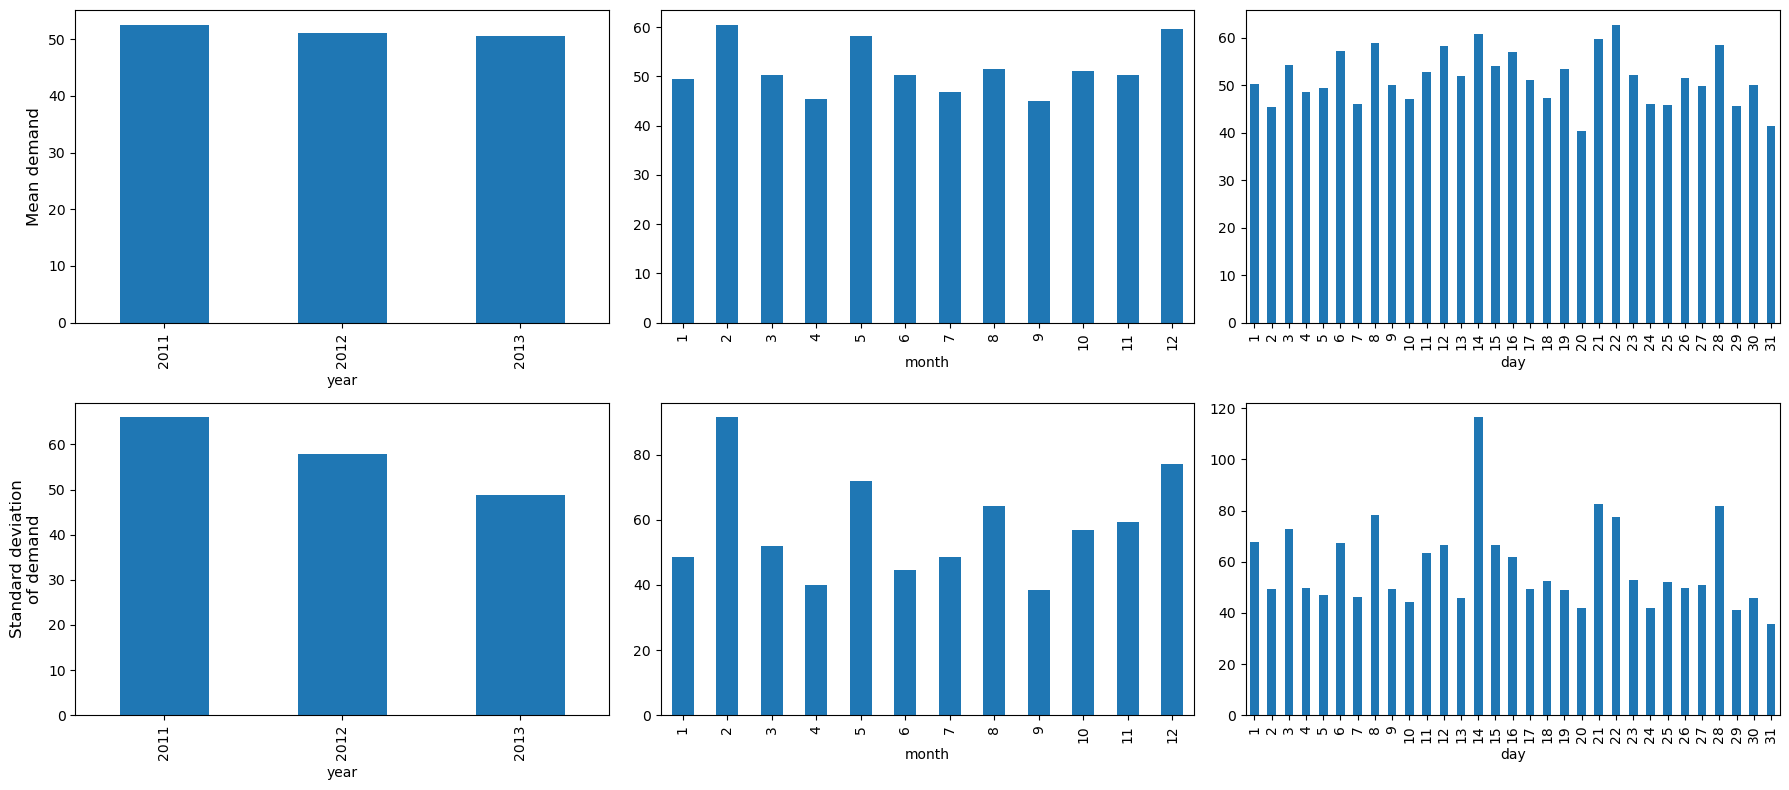

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

for col, col_name in enumerate(['year', 'month', 'day']):
    train_data.groupby(col_name)['units_sold'].mean().plot(kind='bar', ax=axes[0, col], legend=False)
    train_data.groupby(col_name)['units_sold'].std().plot(kind='bar', ax=axes[1, col], legend=False)
    
axes[0,0].set_ylabel('Mean demand', fontsize=12)
axes[1,0].set_ylabel('Standard deviation\nof demand', fontsize=12)
fig.tight_layout()

There does not appear to be any seasonality. There is also no obvious pattern to the months and days across the year. Year on year the mean demand stays very constant although the standard deviation has decreased.

In [13]:
# The 14th day has much more sd, so examining how often dates on the 14th appear
train_data.groupby('day')['units_sold'].count()[14]/sum(train_data.groupby('day')['units_sold'].count())

0.03389830508474576

The reason for the far higher variance on the 14th day of the month is unclear, the number of data points is roughly as would be expected.

A feature will be created to indicate whether the total and base price are the same, or otherwise when when is higher than the other. All three scenarios appear frequently in the data. 

The training data is also split between training and validation data, with 30 weeks now split off for validation.

In [14]:
train_data['equal_price'] = 1*(train_data['total_price']==train_data['base_price'])
train_data['lower_base'] = 1*(train_data['total_price']>train_data['base_price'])
train_data['higher_base'] = 1*(train_data['total_price']<train_data['base_price'])

# Training/validation split
train_data2 = train_data[train_data['week_no']<max(train_data['week_no']-29)].copy()
val_data2 = train_data[train_data['week_no']>=max(train_data['week_no']-29)].copy()

train_data2 = train_data2.groupby(['week', 'is_featured_sku', 'is_display_sku', 'equal_price', 'lower_base', 'higher_base', 'month', 'day'], as_index=False)['units_sold'].sum()
val_data2 = val_data2.groupby(['week', 'is_featured_sku', 'is_display_sku', 'equal_price', 'lower_base', 'higher_base', 'month', 'day'], as_index=False)['units_sold'].sum()
train_data2['cat'] = 'train'
val_data2['cat'] = 'val'

test_data['equal_price'] = 1*(test_data['total_price']==test_data['base_price'])
test_data['lower_base'] = 1*(test_data['total_price']>test_data['base_price'])
test_data['higher_base'] = 1*(test_data['total_price']<test_data['base_price'])
test_data2 = test_data.groupby(['week', 'is_featured_sku', 'is_display_sku', 'equal_price', 'lower_base', 'higher_base', 'month', 'day'], as_index=False)['units_sold'].sum()
test_data2['cat'] = 'test'


Joining the tables so a lag can be added in as a feature.

In [15]:
lag_data = pd.concat([train_data2, val_data2, test_data2]).sort_values(by=['week'])
lag_data['prev_units'] = lag_data.groupby(['is_featured_sku', 'is_display_sku', 'equal_price', 'lower_base', 'higher_base'])['units_sold'].shift(13, fill_value=0)

train_data2 = lag_data[lag_data['cat']=='train']
val_data2 = lag_data[lag_data['cat']=='val']
test_data2 = lag_data[lag_data['cat']=='test']


/var/folders/kf/60czhf056b36zn8cn741kcn80000gn/T/ipykernel_92478/2167672083.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_data2[train_data2.columns[1:]].corr()


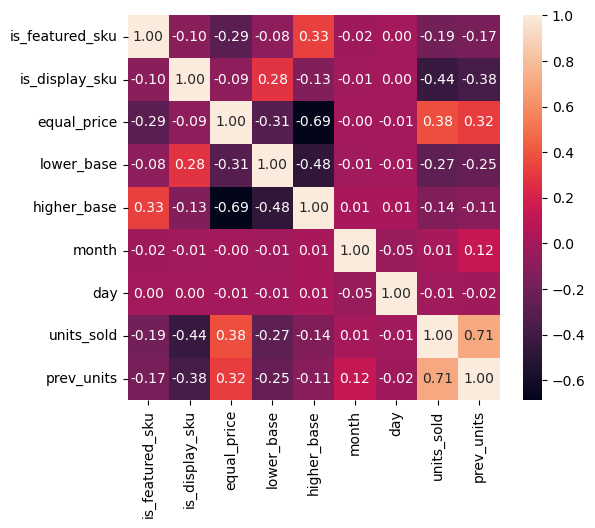

In [16]:
corr = train_data2[train_data2.columns[1:]].corr()

# plot the heatmap
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, annot_kws={'fontsize': 10}, fmt='.2f',
            ax=ax)
plt.show()

There are some pairs with larger correlation. It is unsurprising that an SKU being featured correlates with the price being higher than base price and an SKU being on display correlates with the price being lower than base price. These decisions on pricing and marketing are likely made together. It is perhaps more suprising that the unit sold only has stronger positive correlation with when the items are being sold at the base price.

Both month and day have almost no correlation with anything so can be removed.

In [17]:
train_data2 = train_data2.drop(['month', 'day'], axis=1)
val_data2 = val_data2.drop(['month', 'day'], axis=1)
test_data2 = test_data2.drop(['month', 'day'], axis=1)

Now will check each of the new groups for seasonality. If there is still none, then it will likely be more challenging to predict the future data correctly.

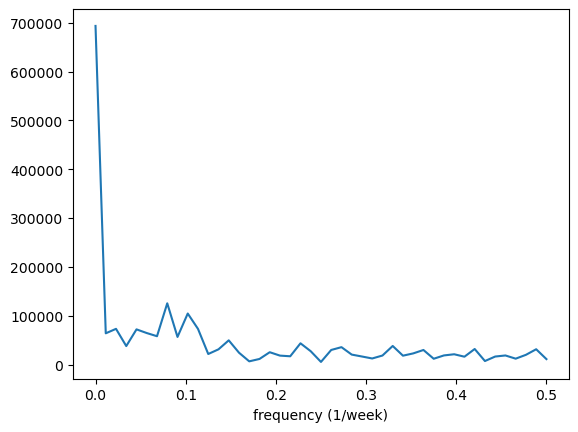

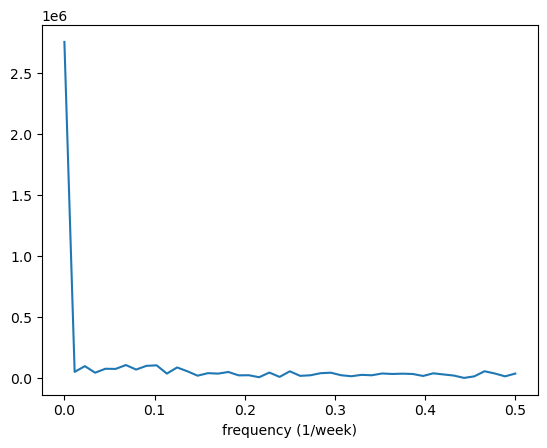

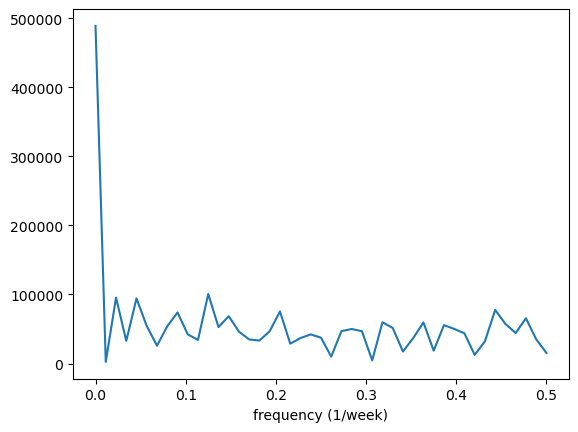

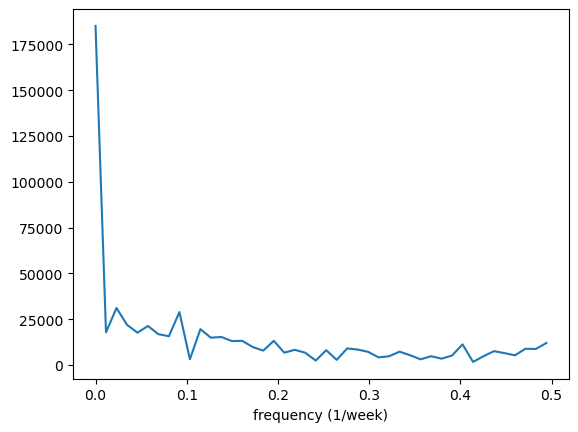

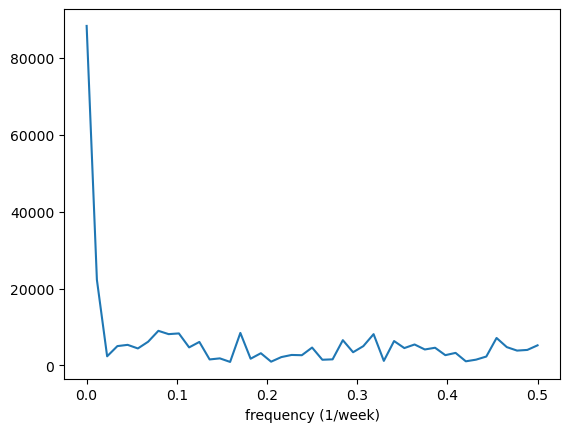

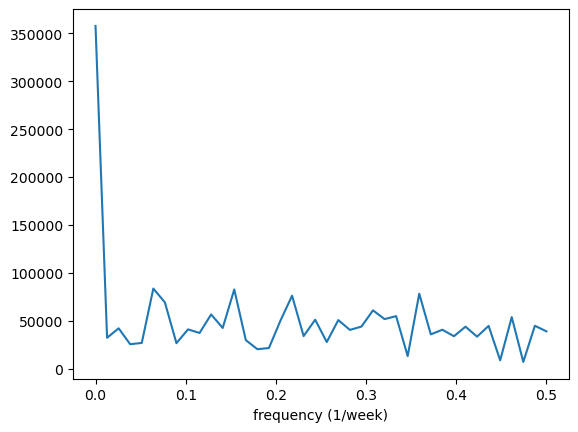

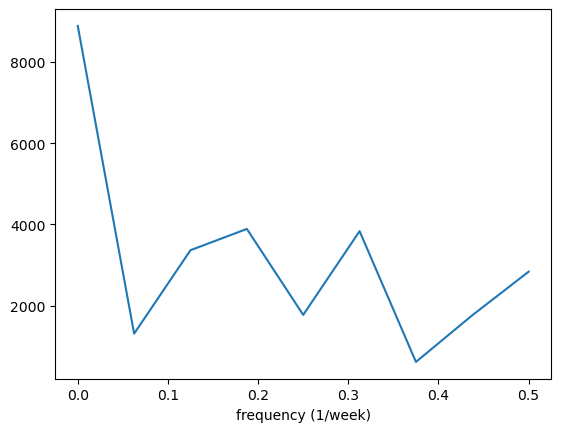

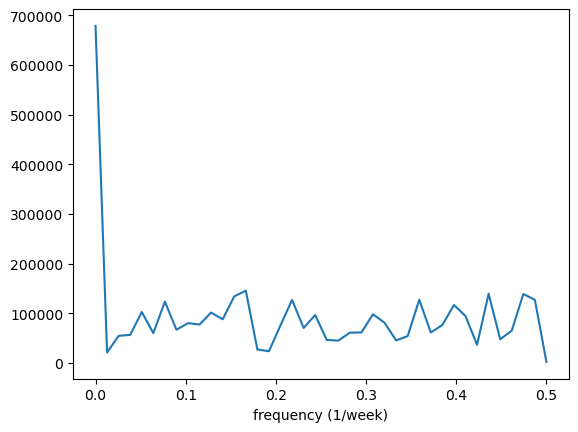

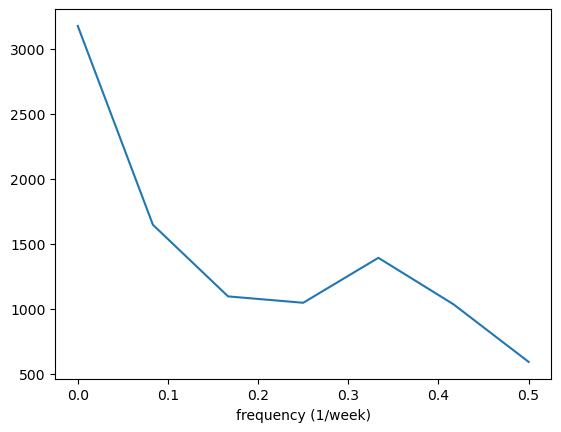

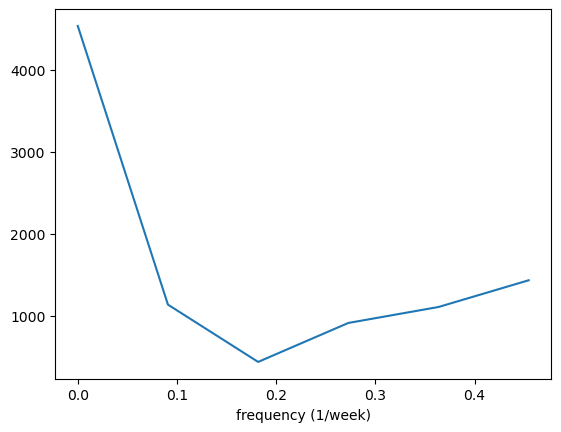

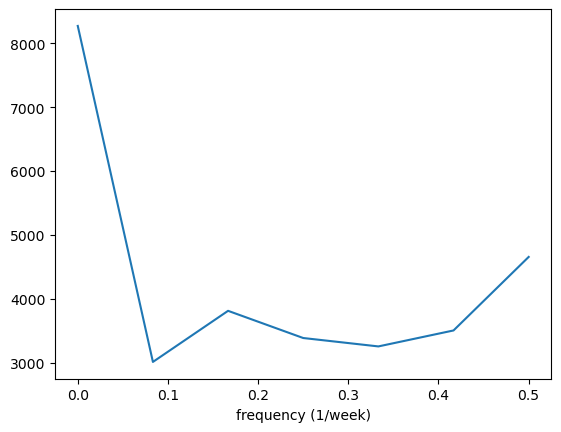

In [18]:
plt_data = train_data2.copy()
plt_data['desc'] = plt_data['is_featured_sku'].astype(str)+plt_data['is_display_sku'].astype(str)+plt_data['equal_price'].astype(str)+plt_data['higher_base'].astype(str)+plt_data['lower_base'].astype(str)
check_list = pd.unique(plt_data['desc'])

for i in check_list:
    plt_data2 = plt_data[plt_data['desc']==i]
    x = list(range(len(plt_data2.index))) 
    y = plt_data2['units_sold']

    # Absolute value of the Fourier transform
    f=abs(np.fft.rfft(y))

    # List of frequencies
    freq = np.fft.rfftfreq(len(x))

    plt.plot(freq, f)
    
    plt.xlabel('frequency (1/week)')
    plt.show()

Also looking at an individual store, individual sku and individual store/sku combination.

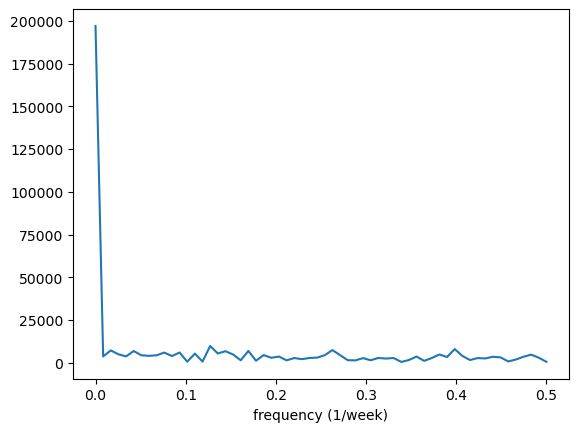

In [19]:
plt_data = train_data[train_data['store_id']==9112]
plt_data = plt_data.groupby(["week"], as_index=False)["units_sold"].sum()

x = list(range(len(plt_data.index))) 
y = plt_data['units_sold']

# Absolute value of the Fourier transform
f=abs(np.fft.rfft(y))

# List of frequencies
freq = np.fft.rfftfreq(len(x))

plt.plot(freq, f)
    
plt.xlabel('frequency (1/week)')
plt.show()

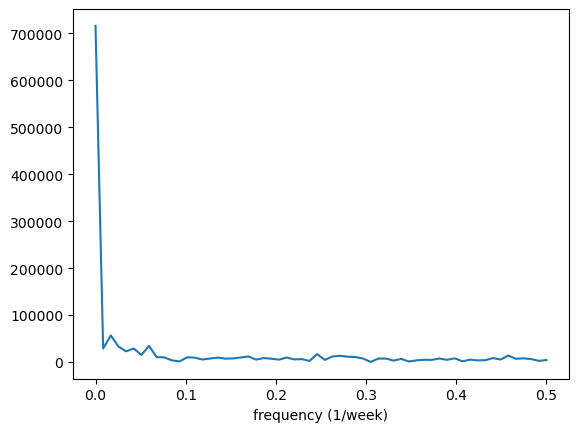

In [20]:
plt_data = train_data[train_data['sku_id']==216418]
plt_data = plt_data.groupby(["week"], as_index=False)["units_sold"].sum()

x = list(range(len(plt_data.index))) 
y = plt_data['units_sold']

# Absolute value of the Fourier transform
f=abs(np.fft.rfft(y))

# List of frequencies
freq = np.fft.rfftfreq(len(x))

plt.plot(freq, f)
    
plt.xlabel('frequency (1/week)')
plt.show()

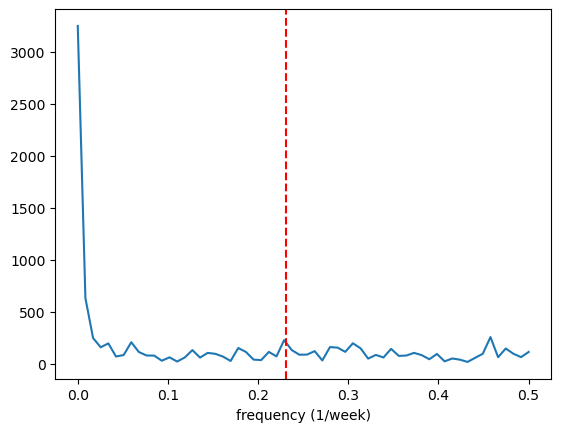

In [21]:
plt_data = train_data[train_data['sku_id']==216418]
plt_data = plt_data[plt_data['store_id']==8091]
plt_data = plt_data.groupby(["week"], as_index=False)["units_sold"].sum()

x = list(range(len(plt_data.index))) 
y = plt_data['units_sold']

# Absolute value of the Fourier transform
f=abs(np.fft.rfft(y))

# List of frequencies
freq = np.fft.rfftfreq(len(x))

plt.plot(freq, f)
    
plt.xlabel('frequency (1/week)')
plt.axvline(x=1/4.33333, color='red', linestyle='dashed')
plt.show()

There is still no seasonality really showing in any of these plots. A tiny peak coincides with 4.3333 weeks in the final plot of a single store and sku combination. This would correspond to a month, and could potentially be suppressed by the data being in a weekly format as two dates will almost never be exactly a month apart but rather 4 or 5.

<a id='baselines'></a>
## Baselines
[Back to contents](#contents)

The initial baseline is to predict the value seen in the previous month. An alternative is to consider the average of a certain number of months. Both of these can be done using the stores and SKUs grouped together.

1. [One time step](#ots)
2. [4/5 time steps](#45ts)
3. [13 week time step](#13ts)

<a id='ots'></a>
### One time step
[Back to baselines](#baselines)

In [22]:
base_all = raw_data.copy()
base_all['test'] = base_all['week_no']>=max(base_all['week_no']-11)

test_all = base_all.groupby(['week','test'], as_index=False)["units_sold"].sum().sort_values('week', ascending=False)
test_all2 = pd.concat([test_all['units_sold'].shift(-1), test_all['units_sold']], axis=1)
test_all2.columns = ['pred', 'real']
test_all = test_all.join(test_all2)
test_all = test_all[test_all['test']==True]
test_all.sort_index(inplace=True)

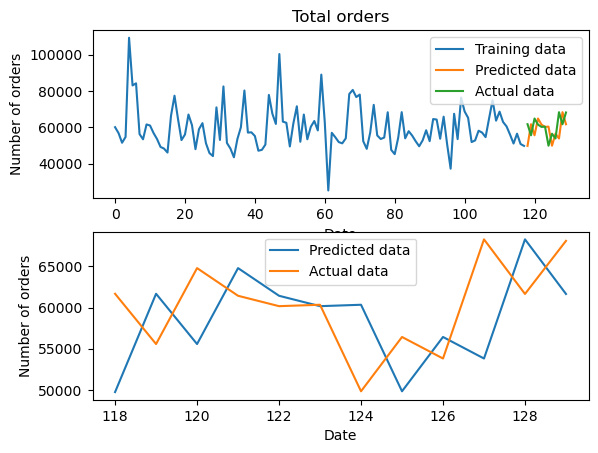

RMSE:  7814.97463207655


In [23]:
train_all = train_data.groupby(['week'], as_index=False)["units_sold"].sum().sort_values('week', ascending=False)

plt.subplot(2, 1, 1)

plt.plot(train_all['units_sold'], label='Training data')
plt.plot([None for i in train_all['units_sold']] + [x for x in test_all['pred']], label='Predicted data')
plt.plot([None for i in train_all['units_sold']] + [x for x in test_all['real']], label='Actual data')

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.legend()
plt.title('Total orders')

plt.subplot(2, 1, 2)

plt.plot(test_all['pred'], label='Predicted data')
plt.plot(test_all['real'], label='Actual data')

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.legend()

plt.show()

print("RMSE: ", np.sqrt(np.square(np.subtract(test_all['real'], test_all['pred'])).mean()))

<a id='45ts'></a>
### 4/5 time steps
[Back to baselines](#baselines)

It may be better to try 4 or 5 weeks earlier if there really is monthly seasonality.

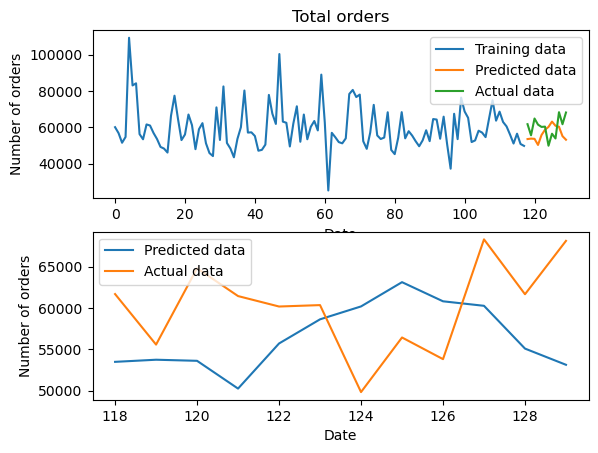

RMSE:  8537.985011845594


In [24]:
base_all = raw_data.copy()
base_all['test'] = base_all['week_no']>=max(base_all['week_no']-11)

test_all = base_all.groupby(['week','test'], as_index=False)["units_sold"].sum().sort_values('week', ascending=False)
test_all2 = pd.concat([test_all['units_sold'].shift(-4), test_all['units_sold']], axis=1)
test_all2.columns = ['pred4', 'real']
test_all = test_all.join(test_all2['pred4'])
test_all2 = pd.concat([test_all['units_sold'].shift(-5), test_all['units_sold']], axis=1)
test_all2.columns = ['pred5', 'real']
test_all = test_all.join(test_all2['pred5'])
test_all['pred'] = test_all[['pred4', 'pred5']].mean(axis=1)
test_all = test_all[test_all['test']==True]
test_all.sort_index(inplace=True)

train_all = train_data.groupby(['week'], as_index=False)["units_sold"].sum().sort_values('week', ascending=False)

plt.subplot(2, 1, 1)

plt.plot(train_all['units_sold'], label='Training data')
plt.plot([None for i in train_all['units_sold']] + [x for x in test_all['pred']], label='Predicted data')
plt.plot([None for i in train_all['units_sold']] + [x for x in test_all['units_sold']], label='Actual data')

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.legend()
plt.title('Total orders')

plt.subplot(2, 1, 2)

plt.plot(test_all['pred'], label='Predicted data')
plt.plot(test_all['units_sold'], label='Actual data')

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.legend()

plt.show()

print("RMSE: ", np.sqrt(np.square(np.subtract(test_all['units_sold'], test_all['pred'])).mean()))


The result for the average of 4 and 5 weeks before is slightly worse. 

<a id='13ts'></a>
### 13 week time step
[Back to baselines](#baselines)

The ultimate task is to predict significantly further ahead though, so will also try 13 weeks ahead as a multiple of 4.3333 and more than the 12 weeks ahead predictions should be made.

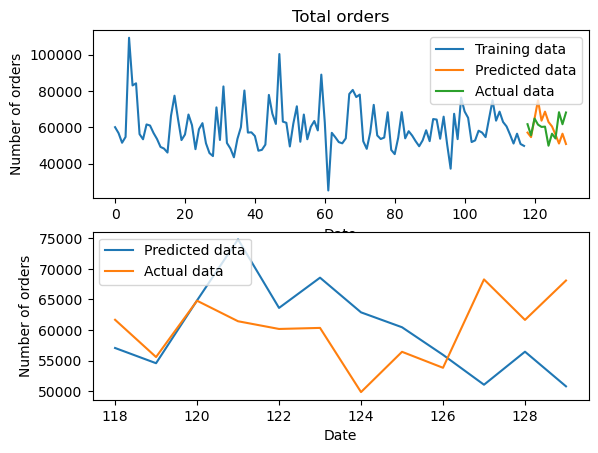

RMSE:  9559.944381811712


In [25]:
base_all = raw_data.copy()
base_all['test'] = base_all['week_no']>=max(base_all['week_no']-11)

test_all = base_all.groupby(['week','test'], as_index=False)["units_sold"].sum().sort_values('week', ascending=False)
test_all2 = pd.concat([test_all['units_sold'].shift(-13), test_all['units_sold']], axis=1)
test_all2.columns = ['pred', 'real']
test_all = test_all.join(test_all2)
test_all = test_all[test_all['test']==True]
test_all.sort_index(inplace=True)

train_all = train_data.groupby(['week'], as_index=False)["units_sold"].sum().sort_values('week', ascending=False)

plt.subplot(2, 1, 1)

plt.plot(train_all['units_sold'], label='Training data')
plt.plot([None for i in train_all['units_sold']] + [x for x in test_all['pred']], label='Predicted data')
plt.plot([None for i in train_all['units_sold']] + [x for x in test_all['real']], label='Actual data')

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.legend()
plt.title('Total orders')

plt.subplot(2, 1, 2)

plt.plot(test_all['pred'], label='Predicted data')
plt.plot(test_all['real'], label='Actual data')

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.legend()

plt.show()

print("RMSE: ", np.sqrt(np.square(np.subtract(test_all['real'], test_all['pred'])).mean()))

<a id='models'></a>
## Models
[Back to contents](#contents)

A range of different models would be suitable for this task.

1. [Statistical](#stats)
2. [Regression](#regress)
3. [Neural networks](#nn)

<a id='stats'></a>
### Statistical
[Back to models](#models)

If there really is no seasonality, then the statistical model to use is ARMA if the data is stationary. If it is not stationary then ARIMA would be more appropriate. This was partially based on https://builtin.com/data-science/time-series-forecasting-python.

In [26]:
train_arima = train_data.groupby(['week'], as_index=False)['units_sold'].sum()
test_arima = test_data.groupby(['week'], as_index=False)['units_sold'].sum()

rolmean = train_arima['units_sold'].rolling(window=12).mean() 
rolstd = train_arima['units_sold'].rolling(window=12).std()

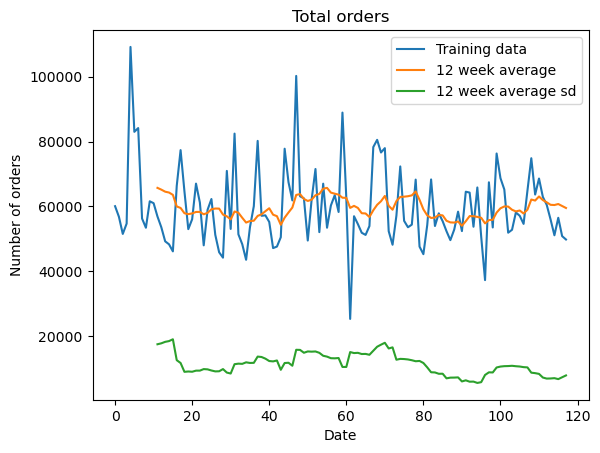

In [27]:
plt_data = train_data.groupby(["week"], as_index=False)["units_sold"].sum()

plt.plot(plt_data['units_sold'], label = 'Training data')
plt.plot(rolmean, label = '12 week average')
plt.plot(rolstd, label = '12 week average sd')

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.title('Total orders')
plt.legend()

plt.show()

Although the mean stays constant, the standard deviation does decrease slightly over time. The time series does appear to be largely stationary, but the change in standard deviation could mean ARIMA works better. 

#### ARMA

In [28]:
y = train_arima['units_sold']
model = SARIMAX(y, order=(1, 0, 1))
results = model.fit()

test_real = test_arima['units_sold']
test_pred = results.predict(start = 1, end = len(test_real))
test_pred.index = test_pred.index-1


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09279D+01    |proj g|=  1.09091D-01

At iterate    5    f=  1.08921D+01    |proj g|=  1.85308D-02

At iterate   10    f=  1.08699D+01    |proj g|=  1.03720D-02

At iterate   15    f=  1.08611D+01    |proj g|=  1.49680D-03

At iterate   20    f=  1.08589D+01    |proj g|=  3.24282D-04

At iterate   25    f=  1.08443D+01    |proj g|=  6.86379D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     32      1     0     0   

 This problem is unconstrained.


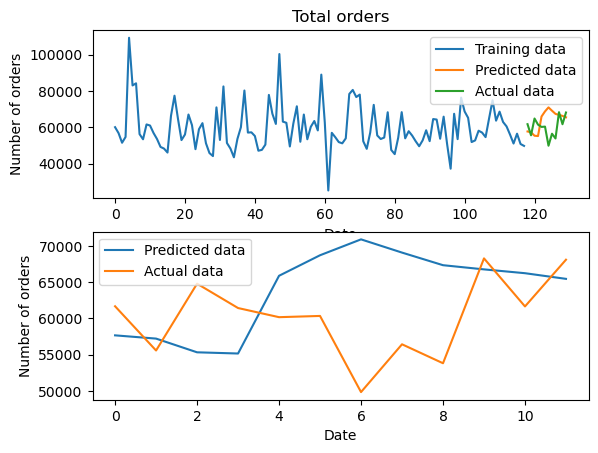

RMSE:  9431.91016136988


In [29]:
plt.subplot(2, 1, 1)

plt.plot(train_all['units_sold'], label='Training data')
plt.plot([None for i in train_all['units_sold']] + [x for x in test_pred], label='Predicted data')
plt.plot([None for i in train_all['units_sold']] + [x for x in test_real], label='Actual data')

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.legend()
plt.title('Total orders')

plt.subplot(2, 1, 2)

plt.plot(test_pred, label='Predicted data')
plt.plot(test_real, label='Actual data')

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.legend()

plt.show()

print("RMSE: ", np.sqrt(np.square(np.subtract(test_real, test_pred)).mean()))

#### ARIMA

In [30]:
best_rmse=10000
best_ijk=[]
for i in range(15):
    for j in range(15):
        for k in range(1):
            model = ARIMA(y, order = (i, j, k))
            results = model.fit() # method_kwargs={'maxiter':500} didn't cause any more to converge

            test_pred = results.predict(start = 1, end = len(test_real))
            test_pred.index = test_pred.index-1
    
            new_rmse=np.sqrt(np.square(np.subtract(test_real, test_pred)).mean())
            if new_rmse<best_rmse:
                best_rmse=new_rmse
                best_ijk = [i,j,k]
print("Best:", best_ijk)

/Users/abigailhayes/opt/anaconda3/envs/AI_FSS23/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/abigailhayes/opt/anaconda3/envs/AI_FSS23/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/abigailhayes/opt/anaconda3/envs/AI_FSS23/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/abigailhayes/opt/anaconda3/envs/AI_FSS23/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Like

Best: [0, 0, 0]


/Users/abigailhayes/opt/anaconda3/envs/AI_FSS23/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


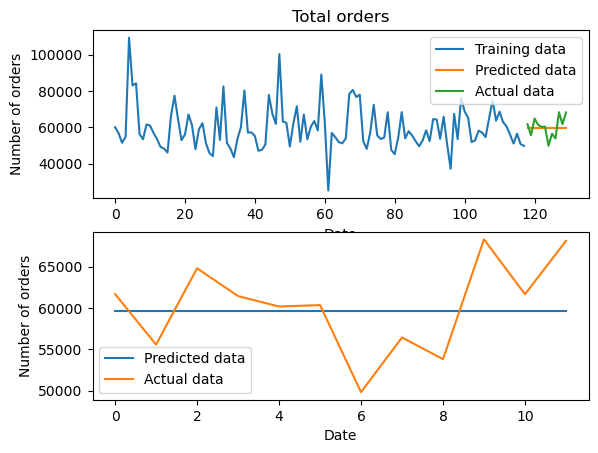

RMSE:  5337.6012502414


In [31]:
model = ARIMA(y, order = (best_ijk[0], best_ijk[1], best_ijk[2]))
results = model.fit()

test_pred = results.predict(start = 1, end = len(test_real))
test_pred.index = test_pred.index-1

plt.subplot(2, 1, 1)

plt.plot(train_all['units_sold'], label='Training data')
plt.plot([None for i in train_all['units_sold']] + [x for x in test_pred], label='Predicted data')
plt.plot([None for i in train_all['units_sold']] + [x for x in test_real], label='Actual data')

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.legend()
plt.title('Total orders')

plt.subplot(2, 1, 2)

plt.plot(test_pred, label='Predicted data')
plt.plot(test_real, label='Actual data')

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.legend()

plt.show()

print("RMSE: ", np.sqrt(np.square(np.subtract(test_real, test_pred)).mean()))

So, the data is being predicted fairly badly by any of these methods. Although this latest 'model' beats the baseline, it is not really modelling anything.

<a id='regress'></a>
### Regression
[Back to models](#models)

One of the notebooks working on this challenge whilst it was live had improved results from using a Random Forest Regressor. They only evaluated their results by submitting them to the competition so it is unclear exactly how well the model worked.

Here two models are built, one using the data without the previous data point, and one including that as a feature.

In [32]:
features = ['is_featured_sku', 'is_display_sku', 'equal_price', 'lower_base', 'higher_base']
features2 = ['is_featured_sku', 'is_display_sku', 'equal_price', 'lower_base', 'higher_base', 'prev_units']
target = ['units_sold']

X_train, X_val, X_test = train_data2[features].values, val_data2[features].values, test_data2[features].values
X_train2, X_val2, X_test2 = train_data2[features2].values, val_data2[features2].values, test_data2[features2].values
y_train, y_val, y_test = train_data2[target].values, val_data2[target].values, test_data2[target].values

X = np.append(X_train, X_val, axis=0)
X2 = np.append(X_train2, X_val2, axis=0)
y = np.append(y_train, y_val, axis=0)

#### Without previous value as feature

In [33]:
reg = RandomForestRegressor()
reg.fit(X, np.array(y).ravel().tolist())
y_pred = reg.predict(X_test)

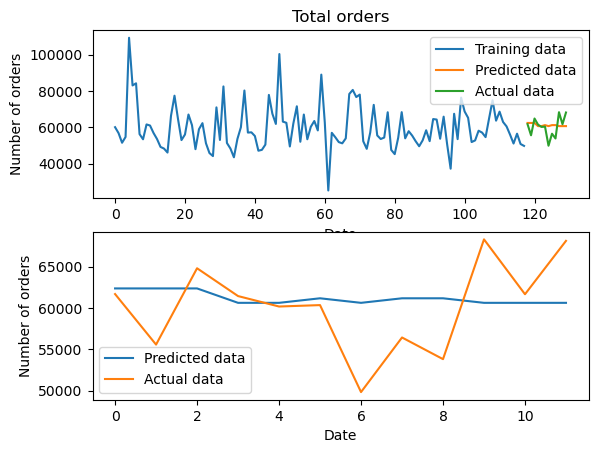

RMSE:  5494.987311573459


In [34]:
test_eval = test_data2.copy()
test_eval['pred']=y_pred
test_eval = test_eval.groupby('week', as_index=False)[['units_sold', 'pred']].sum()

plt.subplot(2, 1, 1)

plt.plot(train_all['units_sold'], label='Training data')
plt.plot([None for i in train_all['units_sold']] + [x for x in test_eval['pred']], label='Predicted data')
plt.plot([None for i in train_all['units_sold']] + [x for x in test_eval['units_sold']], label='Actual data')

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.legend()
plt.title('Total orders')

plt.subplot(2, 1, 2)

plt.plot(test_eval['pred'], label='Predicted data')
plt.plot(test_eval['units_sold'], label='Actual data')

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.legend()

plt.show()

print("RMSE: ", np.sqrt(np.square(np.subtract(test_eval['units_sold'], test_eval['pred'])).mean()))

#### WIth previous value as feature

Now also including the feature created for the value 13 weeks earlier.

In [35]:
reg = RandomForestRegressor()
reg.fit(X2, np.array(y).ravel().tolist())
y_pred = reg.predict(X_test2)

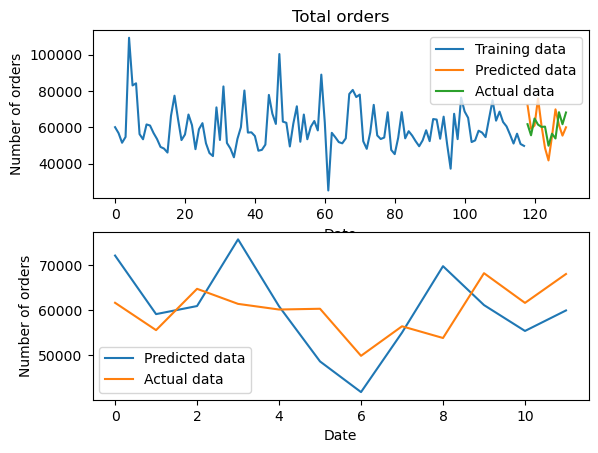

RMSE:  8968.859702733644


In [36]:
test_eval = test_data2.copy()
test_eval['pred']=y_pred
test_eval = test_eval.groupby('week', as_index=False)[['units_sold', 'pred']].sum()

plt.subplot(2, 1, 1)

plt.plot(train_all['units_sold'], label='Training data')
plt.plot([None for i in train_all['units_sold']] + [x for x in test_eval['pred']], label='Predicted data')
plt.plot([None for i in train_all['units_sold']] + [x for x in test_eval['units_sold']], label='Actual data')

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.legend()
plt.title('Total orders')

plt.subplot(2, 1, 2)

plt.plot(test_eval['pred'], label='Predicted data')
plt.plot(test_eval['units_sold'], label='Actual data')

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.legend()

plt.show()

print("RMSE: ", np.sqrt(np.square(np.subtract(test_eval['units_sold'], test_eval['pred'])).mean()))

The root mean squared error is worse with the second model that includes the previous data point. However, this may be because the data can be fairly well predicted by a horizontal line. Although the second regression is further from the target with RMSE, the shape does actually appear to be closer to the desired values. It correctly has a lower value in the middle of the time period with peaks either side. With more refinement, this indicates that the model is maybe learning more about the actual patterns in the data.

<a id='nn'></a>
### Neural networks
[Back to models](#models)

Neural networks would now be considered the state of the art machine learning model for this task. For the first neural network, the first set of features is used. This means that in many ways it is not a time series problem as no direct reference is made to earlier data. The models are not saved as they run in a few seconds.

#### Neural network without previous value as feature

In [37]:
lr = 0.2
hidden_nodes = [32, 32, 32]
max_epochs = 150
patience = 25
verbose = 1

model = Sequential()
model.add(Dense(hidden_nodes[0], input_shape=(X_train.shape[1],), activation='relu'))
for n_nodes in hidden_nodes[1:]:
    model.add(Dense(n_nodes, activation='relu'))   
model.add(Dense(1))

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# train MLP with early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
model.fit(X_train, y_train, epochs=max_epochs, batch_size=128, validation_data=(X_val, y_val),
            verbose=verbose, callbacks=[callback])
    
test_predict = model.predict(x=X_test)

Epoch 1/150


2023-05-26 14:27:00.193561: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


6/6 [==============================] - 0s 20ms/step - loss: 171751024.0000 - val_loss: 174189312.0000
Epoch 2/150
6/6 [==============================] - 0s 4ms/step - loss: 131255904.0000 - val_loss: 113452960.0000
Epoch 3/150
6/6 [==============================] - 0s 4ms/step - loss: 95475688.0000 - val_loss: 98458104.0000
Epoch 4/150
6/6 [==============================] - 0s 4ms/step - loss: 83002096.0000 - val_loss: 74091144.0000
Epoch 5/150
6/6 [==============================] - 0s 5ms/step - loss: 63064324.0000 - val_loss: 55682600.0000
Epoch 6/150
6/6 [==============================] - 0s 4ms/step - loss: 48449628.0000 - val_loss: 41671572.0000
Epoch 7/150
6/6 [==============================] - 0s 5ms/step - loss: 41696288.0000 - val_loss: 27843188.0000
Epoch 8/150
6/6 [==============================] - 0s 4ms/step - loss: 36374444.0000 - val_loss: 22115996.0000
Epoch 9/150
6/6 [==============================] - 0s 4ms/step - loss: 31042252.0000 - val_loss: 25462692.0000
Epoch 10

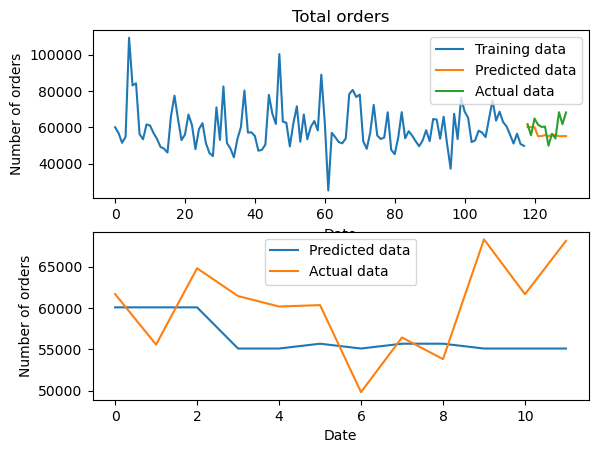

RMSE:  6770.924680871587


In [38]:
test_eval = test_data2.copy()
test_eval['pred']=test_predict
test_eval = test_eval.groupby('week', as_index=False)[['units_sold', 'pred']].sum()

plt.subplot(2, 1, 1)

plt.plot(train_all['units_sold'], label='Training data')
plt.plot([None for i in train_all['units_sold']] + [x for x in test_eval['pred']], label='Predicted data')
plt.plot([None for i in train_all['units_sold']] + [x for x in test_eval['units_sold']], label='Actual data')

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.legend()
plt.title('Total orders')

plt.subplot(2, 1, 2)

plt.plot(test_eval['pred'], label='Predicted data')
plt.plot(test_eval['units_sold'], label='Actual data')

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.legend()

plt.show()

print("RMSE: ", np.sqrt(np.square(np.subtract(test_eval['units_sold'], test_eval['pred'])).mean()))

#### Neural network with previous value as a feature

Now running a neural network with the lag data back to the date 13 weeks earlier.

In [39]:
model = Sequential()
model.add(Dense(hidden_nodes[0], input_shape=(X_train2.shape[1],), activation='relu'))
for n_nodes in hidden_nodes[1:]:
    model.add(Dense(n_nodes, activation='relu'))   
model.add(Dense(1))

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# train MLP with early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
model.fit(X_train2, y_train, epochs=max_epochs, batch_size=128, validation_data=(X_val2, y_val),
            verbose=verbose, callbacks=[callback])
    
test_predict = model.predict(x=X_test2)

Epoch 1/150
6/6 [==============================] - 0s 16ms/step - loss: 287140704.0000 - val_loss: 99334160.0000
Epoch 2/150
6/6 [==============================] - 0s 4ms/step - loss: 95012816.0000 - val_loss: 77957912.0000
Epoch 3/150
6/6 [==============================] - 0s 4ms/step - loss: 91815768.0000 - val_loss: 34667364.0000
Epoch 4/150
6/6 [==============================] - 0s 4ms/step - loss: 72530024.0000 - val_loss: 28858590.0000
Epoch 5/150
6/6 [==============================] - 0s 4ms/step - loss: 71863056.0000 - val_loss: 28361520.0000
Epoch 6/150
6/6 [==============================] - 0s 4ms/step - loss: 65300048.0000 - val_loss: 39729336.0000
Epoch 7/150
6/6 [==============================] - 0s 4ms/step - loss: 67529816.0000 - val_loss: 49422792.0000
Epoch 8/150
6/6 [==============================] - 0s 4ms/step - loss: 76562600.0000 - val_loss: 36307400.0000
Epoch 9/150
6/6 [==============================] - 0s 4ms/step - loss: 80620456.0000 - val_loss: 40645544.0000

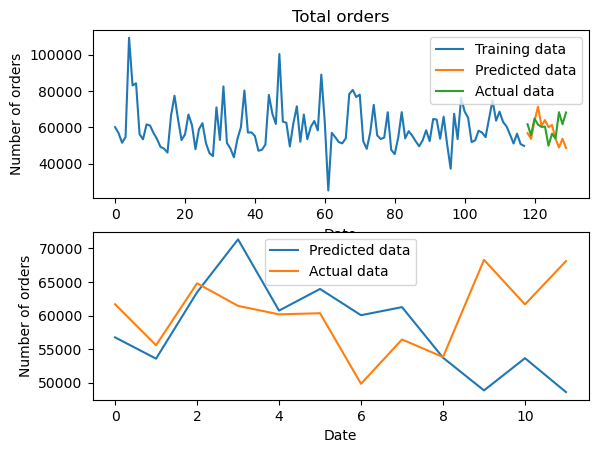

RMSE:  9533.374592394568


In [40]:
test_eval = test_data2.copy()
test_eval['pred']=test_predict
test_eval = test_eval.groupby('week', as_index=False)[['units_sold', 'pred']].sum()

plt.subplot(2, 1, 1)

plt.plot(train_all['units_sold'], label='Training data')
plt.plot([None for i in train_all['units_sold']] + [x for x in test_eval['pred']], label='Predicted data')
plt.plot([None for i in train_all['units_sold']] + [x for x in test_eval['units_sold']], label='Actual data')

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.legend()
plt.title('Total orders')

plt.subplot(2, 1, 2)

plt.plot(test_eval['pred'], label='Predicted data')
plt.plot(test_eval['units_sold'], label='Actual data')

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.legend()

plt.show()

print("RMSE: ", np.sqrt(np.square(np.subtract(test_eval['units_sold'], test_eval['pred'])).mean()))

The performance here is worse. However there has been significant variation when the code was not run with the seed. Sometimes performance improved and other times it didn't. Overall, these results don't suggest that there is a huge amount of information to be gained from specific earlier time points.

#### Average of multiple neural networks

A crude ensemble may improve the results. This is done using the data from the first neural network.

In [41]:
pred_list = []

for i in range(10):
    model = Sequential()
    model.add(Dense(hidden_nodes[0], input_shape=(X_train.shape[1],), activation='relu'))
    for n_nodes in hidden_nodes[1:]:
        model.add(Dense(n_nodes, activation='relu'))   
    model.add(Dense(1))

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    # train MLP with early stopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=max_epochs, batch_size=128, validation_data=(X_val, y_val),
            verbose=verbose, callbacks=[callback])
    
    test_predict = model.predict(x=X_test)
    pred_list.append(test_predict)

Epoch 1/150
6/6 [==============================] - 0s 15ms/step - loss: 179768096.0000 - val_loss: 141744768.0000
Epoch 2/150
6/6 [==============================] - 0s 4ms/step - loss: 137722704.0000 - val_loss: 122908024.0000
Epoch 3/150
6/6 [==============================] - 0s 4ms/step - loss: 128024512.0000 - val_loss: 116948384.0000
Epoch 4/150
6/6 [==============================] - 0s 4ms/step - loss: 101636232.0000 - val_loss: 89989640.0000
Epoch 5/150
6/6 [==============================] - 0s 4ms/step - loss: 84190432.0000 - val_loss: 84579232.0000
Epoch 6/150
6/6 [==============================] - 0s 5ms/step - loss: 71358512.0000 - val_loss: 60276024.0000
Epoch 7/150
6/6 [==============================] - 0s 4ms/step - loss: 49500020.0000 - val_loss: 39852880.0000
Epoch 8/150
6/6 [==============================] - 0s 5ms/step - loss: 38659172.0000 - val_loss: 32515158.0000
Epoch 9/150
6/6 [==============================] - 0s 4ms/step - loss: 37726700.0000 - val_loss: 3047574

Epoch 17/150
6/6 [==============================] - 0s 4ms/step - loss: 28421666.0000 - val_loss: 20036864.0000
Epoch 18/150
6/6 [==============================] - 0s 4ms/step - loss: 28704328.0000 - val_loss: 16219722.0000
Epoch 19/150
6/6 [==============================] - 0s 4ms/step - loss: 28599062.0000 - val_loss: 17699278.0000
Epoch 20/150
6/6 [==============================] - 0s 4ms/step - loss: 27859024.0000 - val_loss: 16400524.0000
Epoch 21/150
6/6 [==============================] - 0s 4ms/step - loss: 28208322.0000 - val_loss: 16490062.0000
Epoch 22/150
6/6 [==============================] - 0s 4ms/step - loss: 28588352.0000 - val_loss: 22047516.0000
Epoch 23/150
6/6 [==============================] - 0s 4ms/step - loss: 33267540.0000 - val_loss: 24886522.0000
Epoch 24/150
6/6 [==============================] - 0s 4ms/step - loss: 35527332.0000 - val_loss: 24883762.0000
Epoch 25/150
6/6 [==============================] - 0s 4ms/step - loss: 31994128.0000 - val_loss: 207572

6/6 [==============================] - 0s 4ms/step - loss: 30681856.0000 - val_loss: 21459290.0000
Epoch 75/150
6/6 [==============================] - 0s 4ms/step - loss: 34779540.0000 - val_loss: 21800326.0000
Epoch 76/150
6/6 [==============================] - 0s 4ms/step - loss: 27988272.0000 - val_loss: 14420180.0000
Epoch 77/150
6/6 [==============================] - 0s 4ms/step - loss: 29387338.0000 - val_loss: 18737442.0000
Epoch 78/150
6/6 [==============================] - 0s 4ms/step - loss: 30315234.0000 - val_loss: 17488280.0000
Epoch 79/150
6/6 [==============================] - 0s 4ms/step - loss: 29489222.0000 - val_loss: 18464446.0000
Epoch 80/150
6/6 [==============================] - 0s 4ms/step - loss: 33460488.0000 - val_loss: 22477910.0000
Epoch 81/150
6/6 [==============================] - 0s 4ms/step - loss: 29493714.0000 - val_loss: 17559672.0000
Epoch 82/150
6/6 [==============================] - 0s 4ms/step - loss: 33698824.0000 - val_loss: 25692218.0000
Epoch

Epoch 64/150
6/6 [==============================] - 0s 4ms/step - loss: 27565820.0000 - val_loss: 15982137.0000
Epoch 65/150
4/4 [==============================] - 0s 688us/step
Epoch 1/150
6/6 [==============================] - 0s 15ms/step - loss: 168166768.0000 - val_loss: 135176400.0000
Epoch 2/150
6/6 [==============================] - 0s 4ms/step - loss: 115366328.0000 - val_loss: 88925488.0000
Epoch 3/150
6/6 [==============================] - 0s 4ms/step - loss: 85557568.0000 - val_loss: 70793384.0000
Epoch 4/150
6/6 [==============================] - 0s 4ms/step - loss: 61712836.0000 - val_loss: 45474256.0000
Epoch 5/150
6/6 [==============================] - 0s 4ms/step - loss: 40467784.0000 - val_loss: 24561654.0000
Epoch 6/150
6/6 [==============================] - 0s 4ms/step - loss: 32280354.0000 - val_loss: 23451274.0000
Epoch 7/150
6/6 [==============================] - 0s 4ms/step - loss: 30301450.0000 - val_loss: 26313964.0000
Epoch 8/150
6/6 [========================

6/6 [==============================] - 0s 4ms/step - loss: 29716652.0000 - val_loss: 23461300.0000
Epoch 79/150
6/6 [==============================] - 0s 4ms/step - loss: 29191742.0000 - val_loss: 14471130.0000
Epoch 80/150
6/6 [==============================] - 0s 4ms/step - loss: 26735040.0000 - val_loss: 16024239.0000
Epoch 81/150
6/6 [==============================] - 0s 4ms/step - loss: 26458760.0000 - val_loss: 16296365.0000
Epoch 82/150
6/6 [==============================] - 0s 4ms/step - loss: 28078286.0000 - val_loss: 21071234.0000
Epoch 83/150
6/6 [==============================] - 0s 4ms/step - loss: 30455054.0000 - val_loss: 15523102.0000
Epoch 84/150
4/4 [==============================] - 0s 694us/step
Epoch 1/150
6/6 [==============================] - 0s 15ms/step - loss: 177375520.0000 - val_loss: 136122224.0000
Epoch 2/150
6/6 [==============================] - 0s 4ms/step - loss: 126863376.0000 - val_loss: 104721384.0000
Epoch 3/150
6/6 [==============================]

Epoch 20/150
6/6 [==============================] - 0s 4ms/step - loss: 28649500.0000 - val_loss: 16775769.0000
Epoch 21/150
6/6 [==============================] - 0s 4ms/step - loss: 27637520.0000 - val_loss: 16932170.0000
Epoch 22/150
6/6 [==============================] - 0s 4ms/step - loss: 26487228.0000 - val_loss: 16359675.0000
Epoch 23/150
6/6 [==============================] - 0s 4ms/step - loss: 26605590.0000 - val_loss: 14210357.0000
Epoch 24/150
6/6 [==============================] - 0s 4ms/step - loss: 27653348.0000 - val_loss: 16634732.0000
Epoch 25/150
6/6 [==============================] - 0s 4ms/step - loss: 27129370.0000 - val_loss: 15015662.0000
Epoch 26/150
6/6 [==============================] - 0s 4ms/step - loss: 26598628.0000 - val_loss: 24172384.0000
Epoch 27/150
6/6 [==============================] - 0s 4ms/step - loss: 39472956.0000 - val_loss: 16526857.0000
Epoch 28/150
6/6 [==============================] - 0s 4ms/step - loss: 28932200.0000 - val_loss: 160202

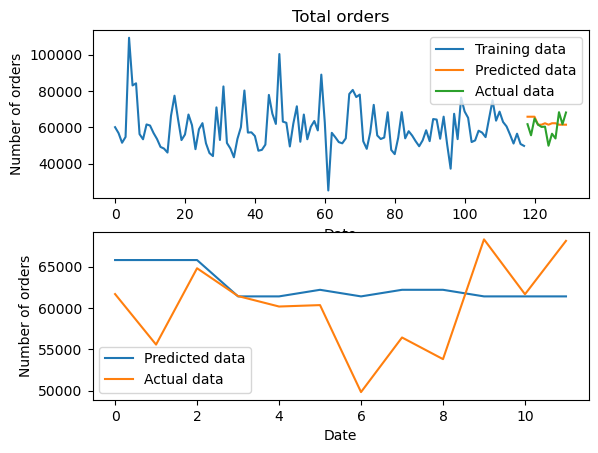

RMSE:  6166.345563961001


In [42]:
test_predict = np.average(np.array(pred_list), axis=0)

test_eval = test_data2.copy()
test_eval['pred']=test_predict
test_eval = test_eval.groupby('week', as_index=False)[['units_sold', 'pred']].sum()

plt.subplot(2, 1, 1)

plt.plot(train_all['units_sold'], label='Training data')
plt.plot([None for i in train_all['units_sold']] + [x for x in test_eval['pred']], label='Predicted data')
plt.plot([None for i in train_all['units_sold']] + [x for x in test_eval['units_sold']], label='Actual data')

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.legend()
plt.title('Total orders')

plt.subplot(2, 1, 2)

plt.plot(test_eval['pred'], label='Predicted data')
plt.plot(test_eval['units_sold'], label='Actual data')

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.legend()

plt.show()

print("RMSE: ", np.sqrt(np.square(np.subtract(test_eval['units_sold'], test_eval['pred'])).mean()))

Although this appears to improve the results, this is likely due to the nature of the technique. Averaging the results from multiple neural networks is likely to result in a flatter line. A flat line has been seen earlier to perform better than most of the other methods.

#### Hyperparameter tuning

In [43]:
def build_model(hp):
    
    model = Sequential()
    model.add(Dense(
        units=hp.Int('dense_1_units', min_value=16, max_value=128, step=16), 
        input_shape=(X_train.shape[1],), activation='relu'))
    for n_nodes in range(hp.Int('nnodes', min_value=0, max_value=5, step=1)):
        model.add(Dense(
            units=hp.Int('dense_{0}_units'.format(n_nodes+2), min_value=16, max_value=128, step=16), 
            activation='relu'))   
    model.add(Dense(1))

    optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Int('lrx10', min_value=1, max_value=5, step=1)/10)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return model

In [44]:
tuner_search = keras_tuner.RandomSearch(build_model,
                                       objective='val_loss',
                                       max_trials=20,
                                       directory = ".",
                                       project_name="nn_param_tune",
                                       overwrite=True)

tuner_search.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val))


Trial 20 Complete [00h 00m 04s]
val_loss: 19785172.0

Best val_loss So Far: 13298514.0
Total elapsed time: 00h 01m 21s
INFO:tensorflow:Oracle triggered exit


In [45]:
tuner_search.results_summary(1)

Results summary
Results in ./nn_param_tune
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 07 summary
Hyperparameters:
dense_1_units: 16
nnodes: 2
lrx10: 1
dense_2_units: 96
dense_3_units: 48
dense_4_units: 16
dense_5_units: 112
Score: 13298514.0


In [46]:
model1, model2, model3 = tuner_search.get_best_models(num_models=3)
test_predict1 = model1.predict(x=X_test)
test_predict2 = model2.predict(x=X_test)
test_predict3 = model3.predict(x=X_test)

4/4 [==============================] - 0s 749us/step


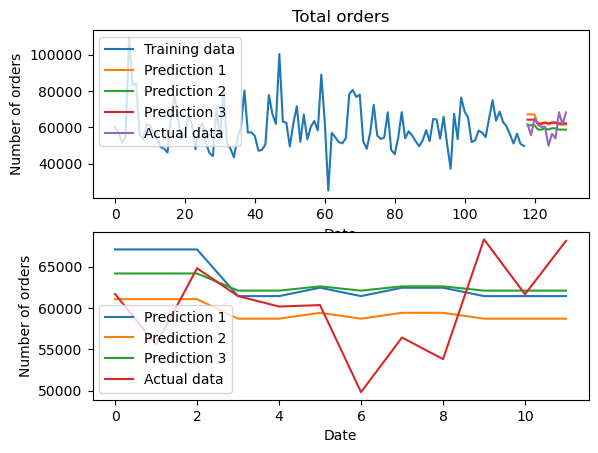

RMSE 1:  6509.710972489242
RMSE 2:  5495.594692756192
RMSE 3:  5983.668989109383


In [47]:
test_eval = test_data2.copy()
test_eval['pred1']=test_predict1
test_eval['pred2']=test_predict2
test_eval['pred3']=test_predict3
test_eval = test_eval.groupby('week', as_index=False)[['units_sold', 'pred1', 'pred2', 'pred3']].sum()

plt.subplot(2, 1, 1)

plt.plot(train_all['units_sold'], label='Training data')
plt.plot([None for i in train_all['units_sold']] + [x for x in test_eval['pred1']], label='Prediction 1')
plt.plot([None for i in train_all['units_sold']] + [x for x in test_eval['pred2']], label='Prediction 2')
plt.plot([None for i in train_all['units_sold']] + [x for x in test_eval['pred3']], label='Prediction 3')
plt.plot([None for i in train_all['units_sold']] + [x for x in test_eval['units_sold']], label='Actual data')

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.legend()
plt.title('Total orders')

plt.subplot(2, 1, 2)

plt.plot(test_eval['pred1'], label='Prediction 1')
plt.plot(test_eval['pred2'], label='Prediction 2')
plt.plot(test_eval['pred3'], label='Prediction 3')
plt.plot(test_eval['units_sold'], label='Actual data')

plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.legend()

plt.show()

print("RMSE 1: ", np.sqrt(np.square(np.subtract(test_eval['units_sold'], test_eval['pred1'])).mean()))
print("RMSE 2: ", np.sqrt(np.square(np.subtract(test_eval['units_sold'], test_eval['pred2'])).mean()))
print("RMSE 3: ", np.sqrt(np.square(np.subtract(test_eval['units_sold'], test_eval['pred3'])).mean()))

Looking at the three 'best' models from the hyperparameter tuning, they all produce fairly flat lines. This fits with the pattern established with the other models.

It may be possible to run hyperparameter tuning such that the final metric can be better accounted for since the 2nd best model outperforms the best for RMSE to the test data. These models are worse than the initial neural network.

It is interesting that all three of the models give very similar predictions. Perhaps this is some feature of how the tuning was set up.

<a id='review'></a>
## Review
[Back to contents](#contents)

The best performing model built here has been the ARIMA(0,0,0) model. This produces a constant and so a horizonatal line as a prediction. This model fitting well indicates that the 'errors' don't show correlation over time. There may however be more reasons. The other models that came close to the same RMSE also predicted fairly flat lines.

Another reason for a horizontal line performing so much better could be the much lower variation between the highest and lowest values in the test data compared to the training data. During the test data the variation is less than 20,000 compared to around 80,000 in the data as a whole.

Such a prediction is not necessarily a problem if a company is looking at the 12 weeks as a whole. 

### Further work

A challenge within this task was the lack of seasonality within the data. Predicting for the overall dataset has not been particularly successful. It was only when looking at the data for one particular store and product combination that there was any suggestion of seasonality.

A further method that might provide more success would be ensemble learning without using the whole dataset for eacg model. Instead, a random selection of the store and sku combinations could be selected and a model built, before the results are then combined. Some of these subsets might indicate seasonality or other patterns inherited from a store and product level.

There was also no limited tuning of the neural network hyperparameters here. Further work may yield improvements to the results. Similarly there could be more experimentation with lag values to include, although there is currently no indication that this would improve the results.